# Plataforma de analise de dados educacionais

## 1. Modelos preditivos


In [101]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed
from tensorflow import set_random_seed

Using TensorFlow backend.


- Devido ao volume de dados, foi recolhida uma amostra da base de dados para execução do protótipo.
- Na plataforma, o acesso aos pode ser feito diretamente ao banco de dados.
- O arquivo CSV corresponde aos dados da tabela enem2017 do banco de dados enem.

## 1. Carregar dados

In [27]:
df =  pd.read_csv('enem2017_sample.csv',sep=';', header=0)

- Mostra informações sobre a amostra de dados

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
nu_inscricao,100000,NaN,NaN,NaN,1.70002e+11,1.76473e+06,1.7e+11,1.70002e+11,1.70002e+11,1.70003e+11,1.70006e+11
nu_ano,100000,NaN,NaN,NaN,2017,0,2017,2017,2017,2017,2017
co_municipio_residencia,100000,NaN,NaN,NaN,3.16389e+06,969263,1.10002e+06,2.6011e+06,3.15461e+06,3.55031e+06,5.30011e+06
no_municipio_residencia,100000,4185,São Paulo,5709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
co_uf_residencia,100000,NaN,NaN,NaN,31.4834,9.66852,11,26,31,35,53
sg_uf_residencia,100000,27,SP,17858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nu_idade,100000,NaN,NaN,NaN,23.4835,7.48579,12,18,21,26,78
tp_sexo,100000,2,F,60808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tp_estado_civil,95736,NaN,NaN,NaN,0.147384,0.410068,0,0,0,0,3
tp_cor_raca,100000,NaN,NaN,NaN,2.09848,1.0081,0,1,2,3,5


## 2. Pré processamento

### 2.1 seleção de features

- Cria variável com a média geral das notas das provas objetivas e de redação, segundo a fórmula:
    
    M = (nu_nota_cn + nu_nota_ch + nu_nota_lc + nu_nota_mt + nu_nota_redacao) / 5
    
    
- Antes altera valores nulos para zero
    


In [29]:
df.nu_nota_ch = df.nu_nota_ch.apply(lambda x: 0 if pd.isnull(x) else x)
df.nu_nota_cn = df.nu_nota_cn.apply(lambda x: 0 if pd.isnull(x) else x)
df.nu_nota_lc = df.nu_nota_lc.apply(lambda x: 0 if pd.isnull(x) else x)
df.nu_nota_mt = df.nu_nota_mt.apply(lambda x: 0 if pd.isnull(x) else x)
df.nu_nota_redacao = df.nu_nota_redacao.apply(lambda x: 0 if pd.isnull(x) else x)


In [34]:
df['nu_media_geral'] = 0

def calculate_mean(row):
    return (row['nu_nota_ch'] + row['nu_nota_cn'] + row['nu_nota_lc'] + row['nu_nota_mt'] + row['nu_nota_redacao'])/5

df['nu_media_geral'] = df.apply(calculate_mean, axis=1)


- Cria variável rotulando os alunos com nota acima de 450 como candidato ao FIES.

1- Indica candidato ao FIES

2- Indica não candidato ao FIES

In [46]:
df['classe_fies'] = 0
df['classe_fies'] = np.where(df.nu_media_geral >= 450, 1, 0)

- Amostra dos dados tratados

In [48]:
df[0:5][['nu_nota_cn' , 'nu_nota_ch','nu_nota_lc','nu_nota_mt','nu_nota_mt','nu_nota_redacao', 'nu_media_geral', 'classe_fies']]

,nu_nota_cn,nu_nota_ch,nu_nota_lc,nu_nota_mt,nu_nota_mt,nu_nota_redacao,nu_media_geral,classe_fies
0,445.4,589.0,621.5,465.5,465.5,560.0,536.28,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0
3,604.0,610.4,563.9,591.2,591.2,580.0,589.90,1
4,482.1,569.2,570.8,584.6,584.6,580.0,557.34,1


- Seleciona features (características) que podem influenciar a notas do estudante nas avaliações.

- Pode se separar os dados do estudante em trẽs grupos de características: pessoais e geográficas, tais como cidade onde mora, cidade da prova, idade, etc.; de saúde e condição física, tais como indicação de doenças crônicas ou limitações físicas; e sócio econômicas, vindas das respostas do questionário sócio econômico. Uma possibilidade do sistema é realizar a análise e redução de características de forma a identificar quais influenciam mais as notas dos alunos. 

- Neste exemplo, foram usadas as características sócio econômicas obtidas pelas respostas ao questionário - campos q001 a q027.

In [151]:
df_avalia = df[['nu_inscricao','q001', 'q002', 'q003', 'q004', 'q005', 'q006', 'q007', 'q008', 'q009', 'q010', 'q011', 'q012', 'q013', 'q014', 'q015', 'q016', 'q017', 'q018', 'q019', 'q020', 'q021', 'q022', 'q023', 'q024', 'q025', 'q026', 'q027', 'classe_fies']]

### 2.2 Encode de variáveis de categoria

- Converter variáveis de tipo categórico ou string para tipos numéricos que podem ser processados pelos modelos de treinamento. As variáveis q001 a q027 serão convertidas para formato numérico.

In [152]:
label_encoder = LabelEncoder()

In [153]:
campos = ['q001', 'q002', 'q003', 'q004','q006', 'q007', 'q008', 'q009', 'q010', 'q011', 'q012', 'q013', 'q014',
       'q015', 'q016', 'q017', 'q018', 'q019', 'q020', 'q021', 'q022', 'q023','q024', 'q025', 'q026', 'q027']
for campo in campos:
    df_avalia[campo] = label_encoder.fit_transform(df_avalia[campo])

/home/09959295800/Programas/anaconda3/envs/desafio/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [154]:
df_avalia.head()

,nu_inscricao,q001,q002,q003,q004,q005,q006,q007,q008,q009,...,q019,q020,q021,q022,q023,q024,q025,q026,q027,classe_fies
0,170003336736,4,3,2,1,3,3,0,1,2,...,2,1,1,2,1,1,1,0,0,1
1,170003333545,2,4,1,1,4,2,0,1,3,...,1,0,0,2,1,0,0,0,0,0
2,170001663644,0,0,5,1,4,6,0,1,2,...,1,0,0,2,0,1,1,0,0,0
3,170001663645,4,3,1,1,4,3,0,1,3,...,2,0,1,3,0,1,1,0,0,1
4,170001663646,0,1,1,5,3,2,0,1,1,...,1,1,0,2,0,2,1,0,0,1


- Exemplo de gráfico, componente do painel de indicadores, mostrando a quantidade de estudantes habilitados para o FIES segundo a resposta q001 = "Até que série seu pai, ou o homem responsável por você, estudou?"

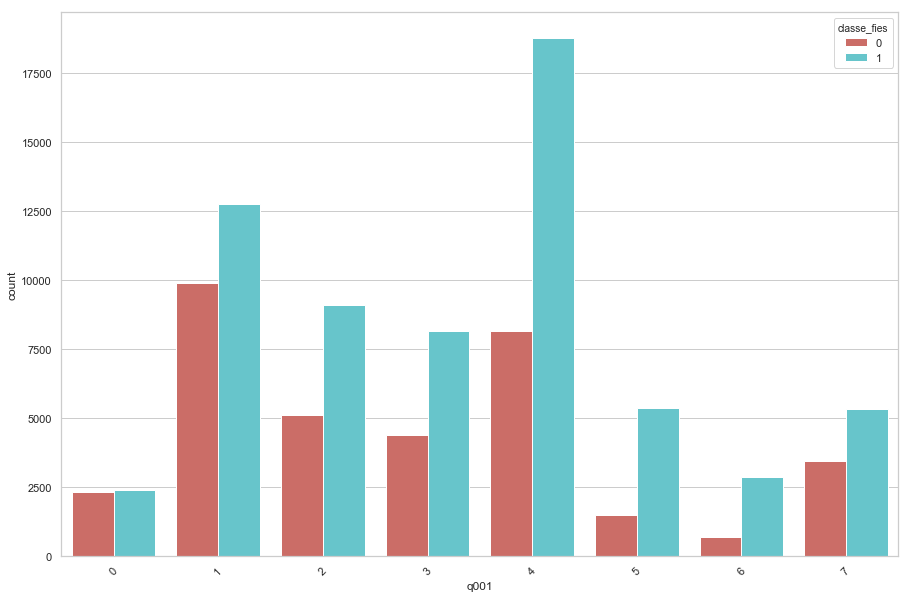

In [155]:
sns.countplot(x='q001', data=df_avalia, palette='hls', hue='classe_fies')
plt.xticks(rotation=45)
plt.show()

### 2.3 Split (separação) de dados

- Separa amostras de treinamento e de teste para execução de algoritmo de treinamento de máquina

In [156]:
X = df_avalia.iloc[:, :-1]
y = df_avalia.iloc[:, -1]

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

- Guarda os dados de treinamento e teste para usar na classificação.

In [158]:
df_train = pd.concat([X_train, y_train], axis=0, sort=True)
df_test = X_test


- Remove o campo identificação do modelo de treinamento, pois ele não contribui pra o modelo

In [159]:
X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]

## 3. Construção e execução da rede neural

- O objetivo da aplicação da rede neural é classificar os estudantes pela probabilidade de obter uma média geral de notas acima de 450, a nota mínima exigida para ingresso no programa FIES.

### 3.1 Construção de modelo de rede neural

- O modelo de rede neural neste protótipo foi mantido simples. Em uma versão produtiva, esse modelo pode ser melhorado para apresentar resultados mais precisos.

In [160]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    set_random_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [161]:
model = create_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8)                 224       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________
None


### 3.2 Treinamento do modelo 

In [162]:
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_acc'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 65.33%


- Análise do treinamento do modelo

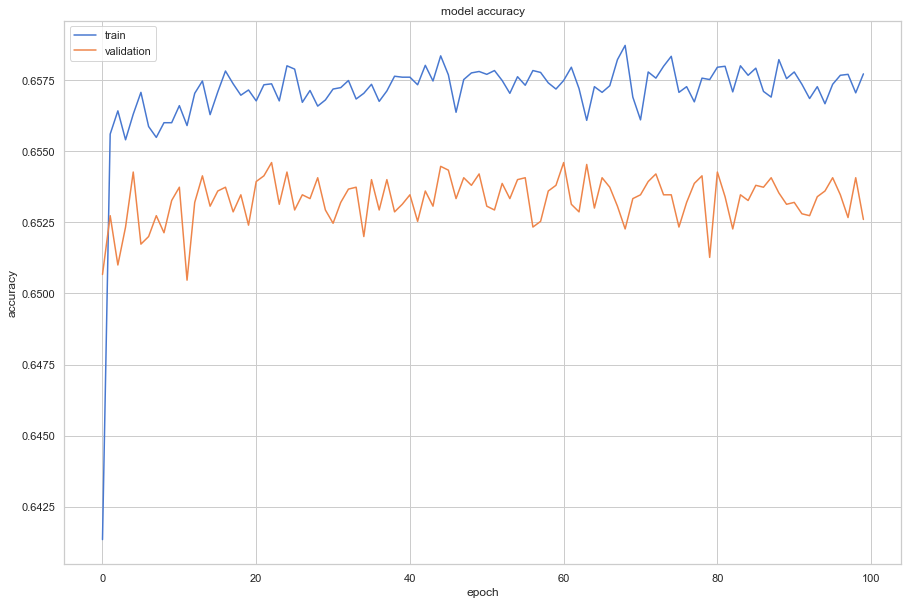

In [163]:
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 3.3 Execução da classificação dos estudantes

- Classificação dos estudantes contidos no conjunto de dados de teste.

In [164]:
df_test['classe_fies'] = model.predict(X_test)
df_test['classe_fies'] = df_test['classe_fies'].apply(lambda x: round(x,0)).astype('int')
solution = df_test[['nu_inscricao', 'classe_fies']]

/home/09959295800/Programas/anaconda3/envs/desafio/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/09959295800/Programas/anaconda3/envs/desafio/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


- Tabela com exemplos de classificação de estudantes habilitados ou não para o FIES.

In [166]:
solution[0:10]

,nu_inscricao,classe_fies
75721,170005046724,1
80184,170003332333,1
19864,170001674114,0
76699,170005041283,1
92991,170001694744,1
76434,170003344994,1
84004,170003329661,0
80917,170005056438,1
60767,170000018505,1
50074,170000004075,1
